<a href="https://colab.research.google.com/github/ricklopez/AAI-521-03-FA22-Intro-Computer-Vision-Team-4/blob/main/team_4_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision Model for Horse Detection in Custom Dataset

### AAI-521-03-FA22 - Intro to Computer Vision

#### Richard Lopez, Ganesh Krishnan, Rodrigo Burberg



#Load Dataset

In [ ]:
# Enabling and testing the GPU
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


##Mount Google Drive

In [ ]:
# Mount the Google Drive to Google Colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Install TensorFlow addons
!pip install -U tensorflow-addons
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 28.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Import Libraries

In [ ]:
# Import all the required libraries
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import os
import scipy.io
import shutil
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers

In [ ]:
# Specify image and annotations data directory
Image_Directory = './gdrive/My Drive/Colab Notebooks/horse_detection/horse_images'
Annotations_Directory = './gdrive/My Drive/Colab Notebooks/horse_detection/horse_annotation'

#EDA

- This dataset only contains images of horses thus any EDA where class analysis is irrelevant for our purposes to detect any class imbalances. 

In [ ]:
# Check the number of leopard images in the dataset
image_paths = []
# os.listdir returns the 'list' of files in the folder, in this case leopard image file names
for i in os.listdir(Image_Directory):
  img = os.path.join(Image_Directory, i)
  image_paths.append(img)
print('Number of images : {} \n'.format(len(image_paths)))
image_paths.sort()

Number of images : 58 



In [ ]:
print(image_paths[0])

./gdrive/My Drive/Colab Notebooks/horse_detection/horse_images/043c1a0785.jpg


In [ ]:
# Check the number of annotated files in the dataset
annot_paths = []
# os.listdir returns the 'list' of files in the folder, in this case annotated file names
for i in os.listdir(Annotations_Directory):
  img = os.path.join(Annotations_Directory, i)
  annot_paths.append(img)
print('Number of annotations files : {} \n'.format(len(annot_paths)))
annot_paths.sort()

Number of annotations files : 58 



In [ ]:
print(annot_paths[0])

./gdrive/My Drive/Colab Notebooks/horse_detection/horse_annotation/043c1a0785_jpg.rf.c2221e2462b05f53f8382e3c1ae31cb2.xml


In [ ]:
import xml.etree.ElementTree as ET


def read_content(xml_file: str):

    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []

    for boxes in root.iter('object'):

        filename = root.find('filename').text

        ymin, xmin, ymax, xmax = None, None, None, None

        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)

        list_with_single_boxes = [xmin, ymin, xmax, ymax]
        list_with_all_boxes.append(list_with_single_boxes)

    return filename, list_with_all_boxes

name, boxes = read_content("./gdrive/My Drive/Colab Notebooks/horse_detection/horse_annotation/043c1a0785_jpg.rf.c2221e2462b05f53f8382e3c1ae31cb2.xml")

In [ ]:
print(name)

043c1a0785_jpg.rf.c2221e2462b05f53f8382e3c1ae31cb2.jpg


In [ ]:
print(boxes)

[[325, 79, 1137, 640]]


<BarContainer object of 256 artists>

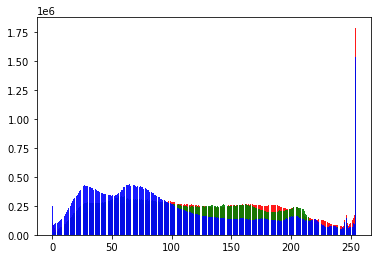

In [ ]:
# This is the histogram for all images in the dataset displaying values for the 
# red green and blue values 

#Import Pillow library
from PIL import Image

nb_bins = 256
count_r = np.zeros(nb_bins)
count_g = np.zeros(nb_bins)
count_b = np.zeros(nb_bins)

for image in os.listdir('./gdrive/My Drive/Colab Notebooks/horse_detection/horse_images'):
  img = Image.open('./gdrive/My Drive/Colab Notebooks/horse_detection/horse_images/'+image)
  x = np.array(img)
  x = x.transpose(2, 0, 1)
  hist_r = np.histogram(x[0], bins=nb_bins, range=[0, 255])
  hist_g = np.histogram(x[1], bins=nb_bins, range=[0, 255])
  hist_b = np.histogram(x[2], bins=nb_bins, range=[0, 255])
  count_r += hist_r[0]
  count_g += hist_g[0]
  count_b += hist_b[0]

bins = hist_r[1]
fig = plt.figure()
plt.bar(bins[:-1], count_r, color='r', alpha=0.9)
plt.bar(bins[:-1], count_g, color='g', alpha=0.9)
plt.bar(bins[:-1], count_b, color='b', alpha=0.9)

(array([ 2.,  0.,  5.,  1.,  1.,  7.,  5., 10.,  1., 15.,  2.,  4.,  0.,
         0.,  3.,  0.,  1.,  0.,  0.,  1.]),
 array([0.65    , 0.770625, 0.89125 , 1.011875, 1.1325  , 1.253125,
        1.37375 , 1.494375, 1.615   , 1.735625, 1.85625 , 1.976875,
        2.0975  , 2.218125, 2.33875 , 2.459375, 2.58    , 2.700625,
        2.82125 , 2.941875, 3.0625  ]),
 <a list of 20 Patch objects>)

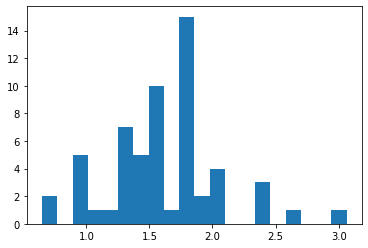

In [ ]:
# this is the asepct ratio before preprocessing the images. 
# The histogram of the resized images should exacted show one value for all images 
aspect_ratio =[]
for image in os.listdir('./gdrive/My Drive/Colab Notebooks/horse_detection/horse_images'):
  im = Image.open('./gdrive/My Drive/Colab Notebooks/horse_detection/horse_images/'+image) 
  width, height = im.size  
  aspect_ratio.append(width/height)

plt.hist(aspect_ratio, bins =20)  # density=False would make counts


(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 58.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ,
        1.05, 1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 ]),
 <a list of 20 Patch objects>)

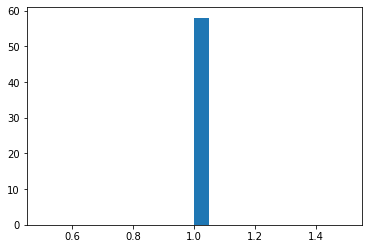

In [ ]:
# As explained above, the histogram corresponds to have all images have the same size

aspect_ratio_resized = []

for image in os.listdir('./gdrive/My Drive/Colab Notebooks/horse_detection/horse_images'):
  im = Image.open('./gdrive/My Drive/Colab Notebooks/horse_detection/horse_images/'+image) 
  new_image = im.resize((224, 224))

  width, height = new_image.size  
  aspect_ratio_resized.append(width/height)

plt.hist(aspect_ratio_resized, bins =20)  # density=False would make counts

In [ ]:
image_size = 224  # resize input images to this size
images, targets = [], []
# loop over the annotations and images, preprocess them and store in lists
for i in range(0, len(annot_paths)):
    # Access bounding box coordinates
    name,boxes = read_content(annot_paths[i])
    top_left_x, top_left_y = boxes[0][0], boxes[0][1]
    bottom_right_x, bottom_right_y = boxes[0][2], boxes[0][3]
    image = keras.utils.load_img(image_paths[i])
    (w, h) = image.size[:2]
    
    # resize train set images
    if i < int(len(annot_paths) * 0.8):
        # resize image if it is for training dataset
        image = image.resize((image_size, image_size))

    # convert image to array and append to list
    images.append(keras.utils.img_to_array(image))

    # apply relative scaling to bounding boxes as per given image and append to list
    targets.append(
        (
            float(top_left_x) / w,
            float(top_left_y) / h,
            float(bottom_right_x) / w,
            float(bottom_right_y) / h,
        )
    )

In [ ]:
len(images)

58

In [ ]:
print(images[0])

[[[133. 132.  73.]
  [112. 108.  58.]
  [139. 134.  72.]
  ...
  [209. 211. 150.]
  [176. 179. 129.]
  [160. 171. 119.]]

 [[144. 143.  86.]
  [141. 138.  79.]
  [153. 150.  87.]
  ...
  [199. 204. 134.]
  [185. 190. 125.]
  [189. 194. 138.]]

 [[124. 123.  67.]
  [137. 135.  69.]
  [153. 150.  86.]
  ...
  [170. 177.  99.]
  [193. 200. 121.]
  [200. 199. 135.]]

 ...

 [[188. 184. 175.]
  [147. 142. 140.]
  [163. 159. 158.]
  ...
  [165. 163. 161.]
  [171. 169. 166.]
  [218. 216. 212.]]

 [[200. 194. 186.]
  [182. 177. 174.]
  [192. 187. 186.]
  ...
  [113. 111. 113.]
  [122. 120. 120.]
  [180. 178. 176.]]

 [[210. 202. 194.]
  [207. 203. 198.]
  [207. 201. 195.]
  ...
  [ 82.  82.  83.]
  [160. 157. 153.]
  [198. 191. 185.]]]


In [ ]:
len(images)

58

In [ ]:
print(targets[0])

(0.2708333333333333, 0.11703703703703704, 0.9475, 0.9481481481481482)


##Split Train and Test Dataset

In [ ]:
# Convert the list to numpy array, split to train and test dataset
(x_train), (y_train) = (
    np.asarray(images[: int(len(images) * 0.8)]),
    np.asarray(targets[: int(len(targets) * 0.8)]),
)
(x_test), (y_test) = (
    np.asarray(images[int(len(images) * 0.8) :]),
    np.asarray(targets[int(len(targets) * 0.8) :]),
)
print('Number of images in training dataset : {} \n'.format(len(x_train)))
print('Number of images in testing dataset : {} \n'.format(len(x_test)))

Number of images in training dataset : 46 

Number of images in testing dataset : 12 



<ipython-input-19-152d804e91cf>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.asarray(images[int(len(images) * 0.8) :]),


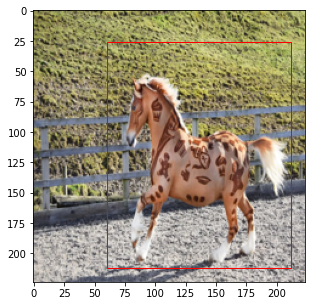

In [ ]:
# Visualizing a sample image with bounding box
input_image = x_train[0]
fig, ax1 = plt.subplots(1, figsize=(5, 5))
im = input_image
# Display the image
ax1.imshow(im.astype("uint8"))
input_image = cv2.resize(input_image,(image_size, image_size),
                         interpolation=cv2.INTER_AREA)
(h, w) = (im).shape[0:2]
top_left_x, top_left_y = int(y_train[0][0] * 224), int(y_train[0][1] * 224)
bottom_right_x, bottom_right_y = int(y_train[0][2] * 224), int(y_train[0][3] * 224)
box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
# Create the bounding box
recta = patches.Rectangle((top_left_x, top_left_y),
                            bottom_right_x - top_left_x,
                            bottom_right_y - top_left_y,
                            facecolor="none",
                            edgecolor="red",
                            linewidth=1,)
ax1.add_patch(recta)
plt.show()

In [ ]:
# Implement multilayer-perceptron (MLP)
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
# Implement the patch creation layer
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    #     Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        # return patches
        return tf.reshape(patches, [batch_size, -1, patches.shape[-1]])

Image size: 224 X 224
Patch size: 32 X 32
49 patches per image 
3072 elements per patch


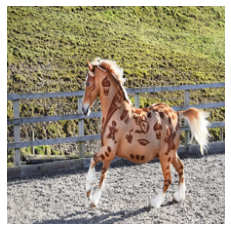

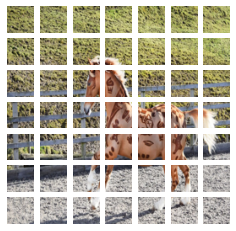

In [ ]:
# Display patches for an input image
plt.figure(figsize=(4, 4))
plt.imshow(x_train[0].astype("uint8"))
plt.axis("off")

patch_size = 32  # Size of the patches to be extracted from the input images
patches = Patches(patch_size)(tf.convert_to_tensor([x_train[0]]))
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
# Patch encoder
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
    # Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
# Build the ViT model
def create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
):
    inputs = layers.Input(shape=input_shape)
    # Create patches
    patches = Patches(patch_size)(inputs)
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.3)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.3)

    bounding_box = layers.Dense(4)(
        features
    )  # Final four neurons that output bounding box

    # return Keras model.
    return keras.Model(inputs=inputs, outputs=bounding_box)

In [ ]:
# Compiling
def run_experiment(model, learning_rate, weight_decay, batch_size, num_epochs):
    optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate,
                                     weight_decay=weight_decay)
    # Compile model.
    model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError())
    checkpoint_filepath = "logs/"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(checkpoint_filepath,
                                                          monitor="val_loss",
                                                          save_best_only=True,
                                                          save_weights_only=True,)
    history = model.fit(x=x_train, 
                        y=y_train, 
                        batch_size=batch_size, 
                        epochs=num_epochs,
                        validation_split=0.1,
                        callbacks=[checkpoint_callback, 
                                   keras.callbacks.EarlyStopping(monitor="val_loss",
                                                                 patience=10),],)
    return history
input_shape = (image_size, image_size, 3)  # input image shape
num_patches = (image_size // patch_size) ** 2
num_heads = 4
projection_dim = 64
# Size of the transformer layers
transformer_units = [projection_dim * 2,projection_dim,]
transformer_layers = 4
mlp_head_units = [2048, 1024, 512, 64, 32]  # Size of the dense layers
history = []
num_patches = (image_size // patch_size) ** 2
vit_object_detector = create_vit_object_detector(input_shape, patch_size, 
                                                 num_patches, projection_dim,
                                                 num_heads, transformer_units,
                                                 transformer_layers, mlp_head_units,)
vit_object_detector.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 patches_1 (Patches)            (None, None, 3072)   0           ['input_1[0][0]']                
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 49, 64)       199808      ['patches_1[0][0]']              
                                                                                                  
 layer_normalization (LayerNorm  (None, 49, 64)      128         ['patch_encoder[0][0]']      

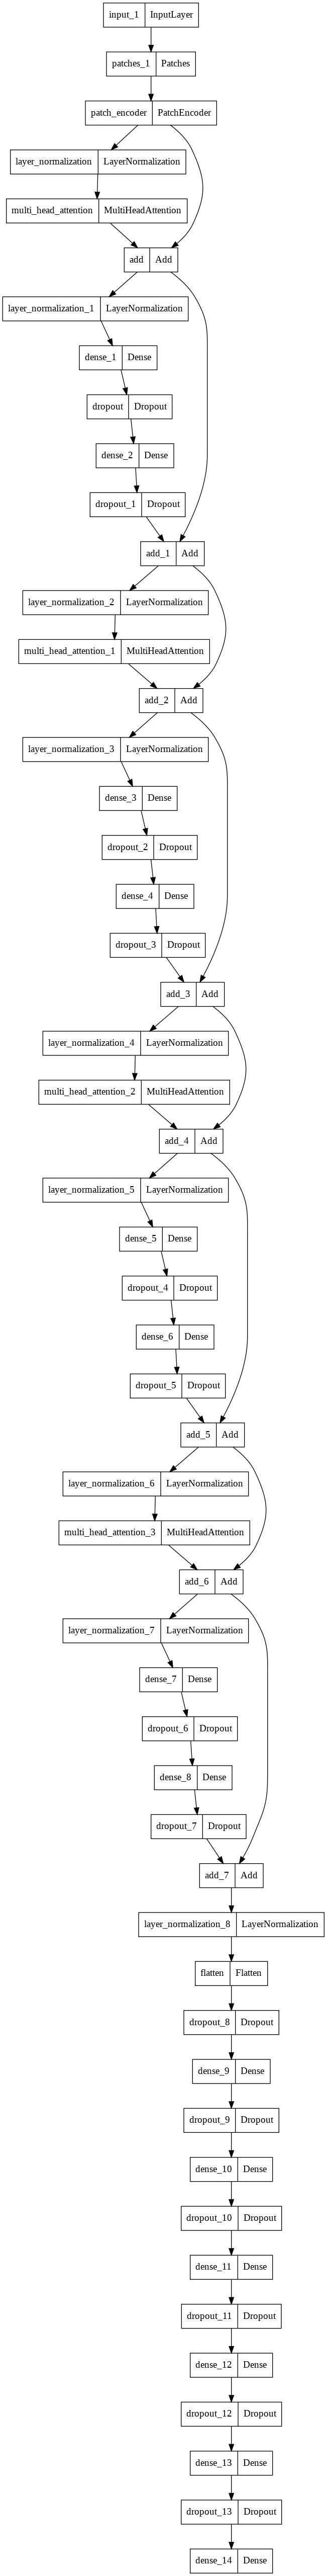

In [ ]:
plot_model(vit_object_detector, to_file='model.png')

The model arcitechure chosen for was a transformer which is a deep learning model that adopts the mechanism of self-attention, differentially weighting the significance of each part of the input data. The model was chosen as it has been very effective in computer vision techniques. Reference: https://arxiv.org/abs/1706.03762

#Train Model

In [ ]:
# Train model
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 100
history = run_experiment(vit_object_detector, learning_rate, weight_decay, 
                         batch_size, num_epochs)
# Saves the model in current path
vit_object_detector.save("./gdrive/My Drive/Colab Notebooks/horse_detection/horse_detector.h5", 
                         save_format="h5")

Epoch 1/100
2/2 [==============================] - 6s 1s/step - loss: 0.1378 - val_loss: 0.1178
Epoch 2/100
2/2 [==============================] - 1s 856ms/step - loss: 0.1303 - val_loss: 0.1131
Epoch 3/100
2/2 [==============================] - 0s 402ms/step - loss: 0.1330 - val_loss: 0.1084
Epoch 4/100
2/2 [==============================] - 0s 418ms/step - loss: 0.1238 - val_loss: 0.1039
Epoch 5/100
2/2 [==============================] - 0s 430ms/step - loss: 0.1221 - val_loss: 0.0995
Epoch 6/100
2/2 [==============================] - 0s 410ms/step - loss: 0.1156 - val_loss: 0.0952
Epoch 7/100
2/2 [==============================] - 0s 423ms/step - loss: 0.1178 - val_loss: 0.0910
Epoch 8/100
2/2 [==============================] - 0s 396ms/step - loss: 0.1054 - val_loss: 0.0869
Epoch 9/100
2/2 [==============================] - 0s 417ms/step - loss: 0.1014 - val_loss: 0.0828
Epoch 10/100
2/2 [==============================] - 0s 402ms/step - loss: 0.0998 - val_loss: 0.0789
Epoch 11/100

##Load Pretrained Weights & Calculate IoU (Intersection over Union)

In [ ]:
# Loading the pretrained weights
vit_object_detector.load_weights("./gdrive/My Drive/Colab Notebooks/horse_detection/horse_detector.h5")

1/1 [==============================] - 0s 25ms/step
mean_iou: 0.5324774084621878


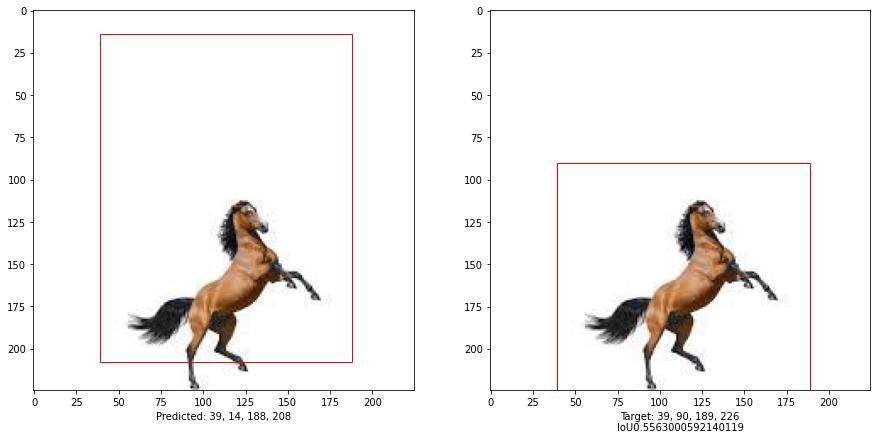

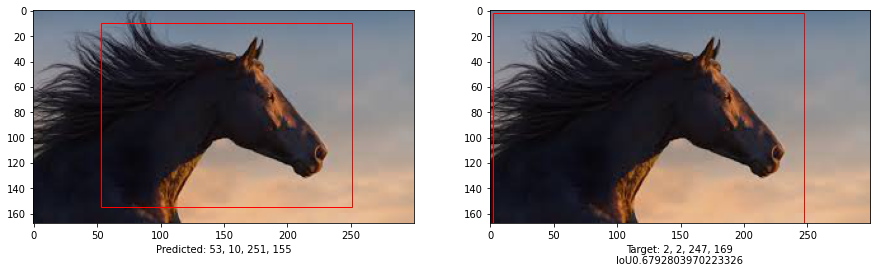

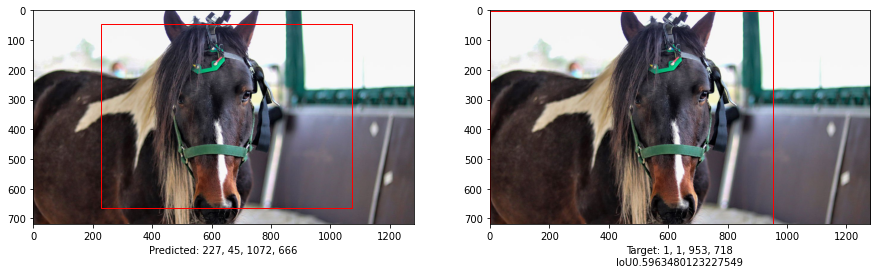

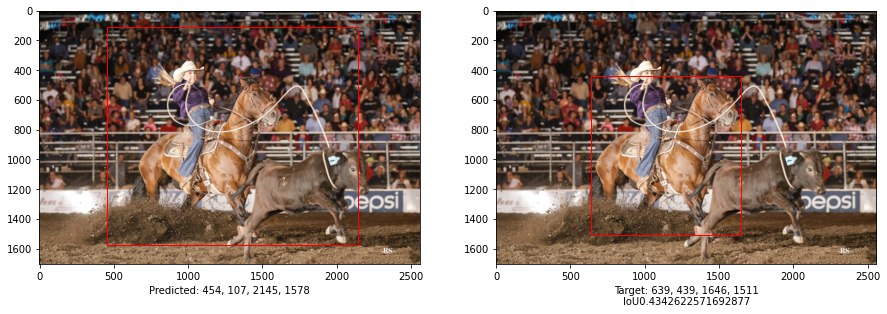

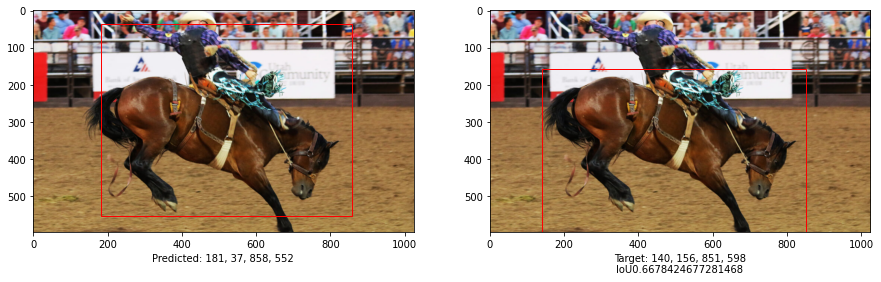

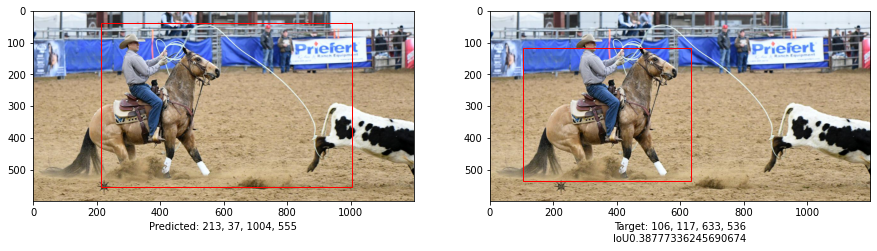

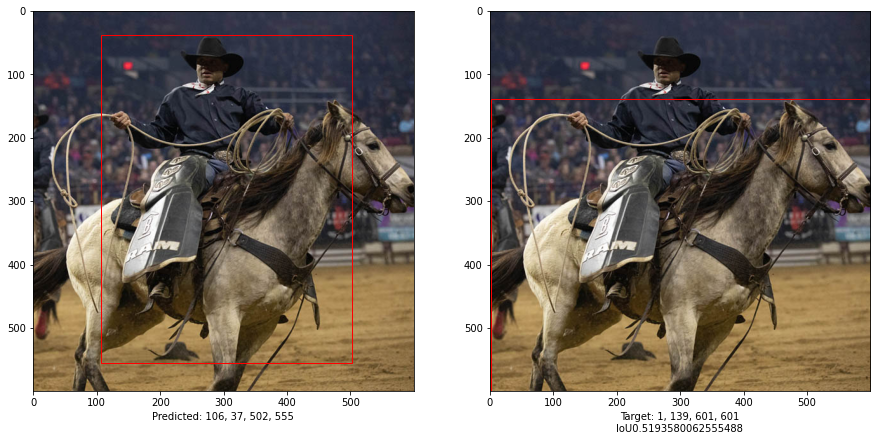

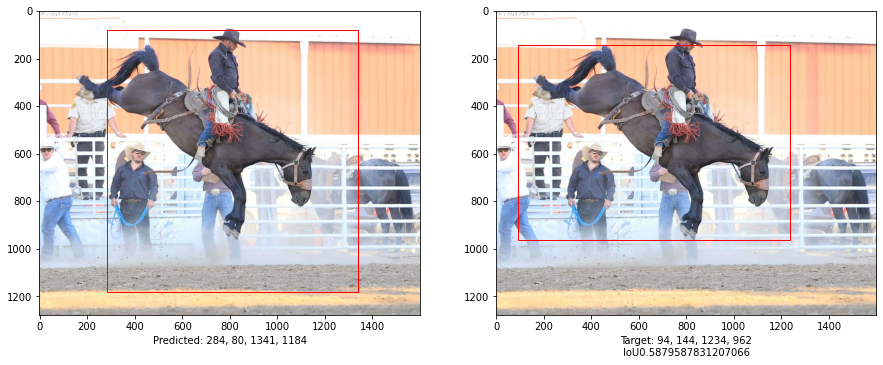

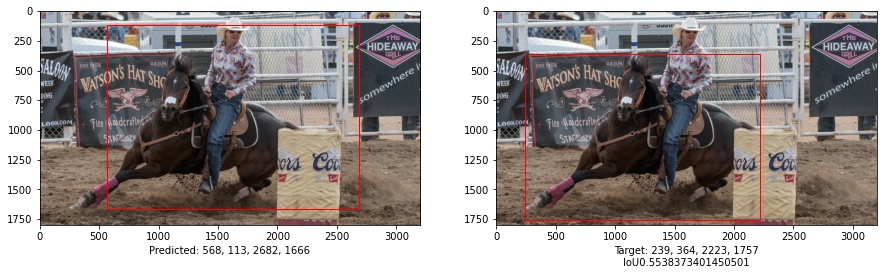

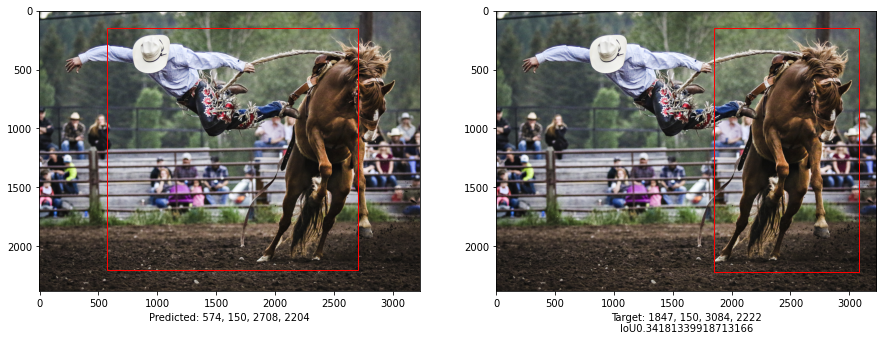

In [ ]:
import matplotlib.patches as patches
# To calculate IoU (intersection over union, given two bounding boxes)
def bounding_box_intersection_over_union(box_predicted, box_truth):
    # get (x, y) coordinates of intersection of bounding boxes
    top_x_intersect = max(box_predicted[0], box_truth[0])
    top_y_intersect = max(box_predicted[1], box_truth[1])
    bottom_x_intersect = min(box_predicted[2], box_truth[2])
    bottom_y_intersect = min(box_predicted[3], box_truth[3])
    # calculate area of the intersection bb (bounding box)
    intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
        0, bottom_y_intersect - top_y_intersect + 1)
    # calculate area of the prediction bb and ground-truth bb
    box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
        box_predicted[3] - box_predicted[1] + 1)
    box_truth_area = (box_truth[2] - box_truth[0] + 1) * (
        box_truth[3] - box_truth[1] + 1)
    # calculate intersection over union by taking intersection
    # area and dividing it by the sum of predicted bb and ground truth
    # bb areas subtracted by  the interesection area
    # return ioU
    return intersection_area / float(
        box_predicted_area + box_truth_area - intersection_area)
i, mean_iou = 0, 0
# Compare results for 10 images in the test set
for input_image in x_test[:10]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    im = input_image
    # Display the image
    ax1.imshow(im.astype("uint8"))
    ax2.imshow(im.astype("uint8"))
    input_image = cv2.resize(input_image, (image_size, image_size), 
                             interpolation=cv2.INTER_AREA)
    input_image = np.expand_dims(input_image, axis=0)
    preds = vit_object_detector.predict(input_image)[0]
    (h, w) = (im).shape[0:2]
    top_left_x, top_left_y = int(preds[0] * w), int(preds[1] * h)
    bottom_right_x, bottom_right_y = int(preds[2] * w), int(preds[3] * h)
    box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    # Create the bounding box
    rect = patches.Rectangle((top_left_x, top_left_y), bottom_right_x - top_left_x,
                             bottom_right_y - top_left_y, facecolor="none",
                             edgecolor="red", linewidth=1,)
    # Add the bounding box to the image
    ax1.add_patch(rect)
    ax1.set_xlabel("Predicted: " + str(top_left_x) + ", " + str(top_left_y)
        + ", " + str(bottom_right_x) + ", " + str(bottom_right_y))
    top_left_x, top_left_y = int(y_test[i][0] * w), int(y_test[i][1] * h)
    bottom_right_x, bottom_right_y = int(y_test[i][2] * w), int(y_test[i][3] * h)
    box_truth = top_left_x, top_left_y, bottom_right_x, bottom_right_y
    mean_iou += bounding_box_intersection_over_union(box_predicted, box_truth)
    # Create the bounding box
    rect = patches.Rectangle((top_left_x, top_left_y), bottom_right_x - top_left_x,
                             bottom_right_y - top_left_y, facecolor="none", 
                             edgecolor="red", linewidth=1,)
    # Add the bounding box to the image
    ax2.add_patch(rect)
    ax2.set_xlabel("Target: " + str(top_left_x) + ", " + str(top_left_y) + ", "
        + str(bottom_right_x) + ", " + str(bottom_right_y) + "\n" + "IoU"
        + str(bounding_box_intersection_over_union(box_predicted, box_truth)))
    i = i + 1
print("mean_iou: " + str(mean_iou / len(x_test[:10])))
plt.show()

## Summary

[See the full in our research paper](https://docs.google.com/document/d/1D5EFHrI0QhTlXJEt6CDd2uAPymdHxh7T-mCbxQHvdp8/edit?usp=sharing)

There is still much room for improvement with this project, namely the ability to detect other object types related to the use case. For example, in a rodeo, we would like to detect athletes, bulls, ropes, barrels, and other objects specific to event types. In addition, we would like to apply our model to video. We could develop a more robust solution ready to test in live events with these enhancements. There is promising research in using ViT for solving video-related object detection tasks. (Selva et al., n.d.) The long-term goal would be to allow users to upload videos and images for the events and automate post-event data entry around participation, scoring, and results. The next step is gathering a larger dataset with the kinds of images we would expect to encounter in the rodeo events. ViT, indeed, is a solid alternative to CNN-based object detection models. However, their performance is very dependent on large training datasets. "ViT models are generally found to perform best in settings with large amounts of training data..." (Steiner et al., n.d.) We just had over 55 images for training. With a larger dataset and increasing the number of epochs, we could improve the performance of our model. This project has given us an excellent foundation to build on. Our ViT model proved that this architecture is a viable approach for developing this kind of Computer Vision powered system.

## References

- Sagar, R. (2021, August 30). Are Visual Transformers Better Than CNNs. Analytics India Magazine. https://analyticsindiamag.com/are-visual-transformers-better-than-convolutional-neural-networks/

- Boesch, G. (2022, March 6). Vision Transformers (ViT) in Image Recognition - 2022 Guide - viso.ai. Viso.ai. https://viso.ai/deep-learning/vision-transformer-vit/#:~:text=Moreover%2C%20ViT%20models%20outperform%20CNNs,to%20computational%20efficiency%20and%20accuracy.

- Sonawani, S., Alimo, R., Detry, R., Jeong, D., Hess, A., & Amor, H. (n.d.). Assistive Relative Pose Estimation for On-orbit Assembly using Convolutional Neural Networks. Retrieved December 10, 2022, from https://arxiv.org/pdf/2001.10673.pdf (Sonawani et al., n.d.)

- Banerjee, S. (2022). Animal Image Dataset (90 Different Animals). Kaggle.com. https://www.kaggle.com/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals
‌
- Nikolas Adaloglou. (2021, January 28). How the Vision Transformer (ViT) works in 10 minutes: an image is worth 16x16 words | AI Summer. AI Summer; Sergios Karagiannakos. https://theaisummer.com/vision-transformer/

- Vision Transformers (ViT) Explained | Pinecone. (2017). Pinecone. https://www.pinecone.io/learn/vision-transformers/

- Boesch, G. (2022, July 16). What is Overfitting in Computer Vision? How to Detect and Avoid it - viso.ai. Viso.ai. https://viso.ai/computer-vision/what-is-overfitting/

- Selva, J., Johansen, A., Escalera, S., Nasrollahi, K., Moeslund, T., & Clapés, A. (n.d.). Video Transformers: A Survey. Retrieved December 12, 2022, from https://arxiv.org/pdf/2201.05991.pdf

- TestEngine. (2021, January 12). Vision Transformers (ViT) - TestEngine. - TestEngine. https://testengine.ai/vision-transformers-vit/

- Steiner, A., Kolesnikov, A., Zhai, X., Wightman, R., Uszkoreit, J., & Beyer, L. (n.d.). How to train your ViT? Data, Augmentation, and Regularization in Vision Transformers. Retrieved December 12, 2022, from https://openreview.net/pdf?id=4nPswr1KcP

- tfa.optimizers.AdamW. (2022). tfa.optimizers.AdamW | TensorFlow Addons. TensorFlow. https://www.tensorflow.org/addons/api_docs/python/tfa/optimizers/AdamW

- labelImg. (2017, July 21). PyPI. https://pypi.org/project/labelImg/1.4.0/

- Solawetz, J. (2020, July 16). How to Train a TensorFlow 2 Object Detection Model. Roboflow Blog; Roboflow Blog. https://blog.roboflow.com/train-a-tensorflow2-object-detection-model/

- Roboflow: Give your software the power to see objects in images and video. (2022). Roboflow.com. https://roboflow.com/
tf.keras.layers.MultiHeadAttention  |  TensorFlow v2.11.0. (2022). TensorFlow. https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention